In [231]:
# Imports and Function Initialization

import numpy as np
import math
from math import log2, sqrt
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import Initialize
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import scipy.stats
import matplotlib.pyplot as plt
from qiskit.circuit.library import RYGate, CCXGate
from collections import deque
from qiskit_aer import AerSimulator

In [232]:
# Choose CDF for INTEGRABLE distributions, some are given

# NOTE feel free to change the values in the function header

def normal_cdf(x, mean=0.5, std=1/6):
    '''
    Normal Distribution
    '''
    return scipy.stats.norm.cdf(x, mean, std)

def uniform_cdf(x, a=0, b=1):
    '''
    Uniform Distribution
    '''
    if (x < a):
        return 0
    if (x > b):
        return 1
    return (x-a)/(b-a)
    
def exponential_cdf(x, lam=5):
    '''
    Exponential Distribution
    '''
    return scipy.stats.expon.cdf(x, scale=1/lam)

num_qubits = 7
cdf = normal_cdf

In [233]:
num_states = 2**num_qubits
state_step = 1 / num_states

# Gather all values into a list
p = []
for i in range(1, num_states + 1):
    state = i * state_step
    p.append(cdf(state) - cdf(state - state_step))

# Normalize the distribution
p = np.array(p)
p = p / np.sum(p)

print(p)

[0.00022358 0.00025677 0.00029423 0.00033643 0.00038383 0.00043694
 0.00049632 0.00056253 0.00063617 0.00071788 0.00080829 0.00090811
 0.001018   0.00113869 0.0012709  0.00141534 0.00157274 0.00174381
 0.00192925 0.00212972 0.00234586 0.00257826 0.00282747 0.00309397
 0.00337816 0.00368035 0.00400078 0.00433956 0.0046967  0.00507207
 0.00546543 0.00587637 0.00630434 0.00674865 0.0072084  0.00768259
 0.00817    0.00866927 0.00917886 0.00969707 0.01022207 0.01075184
 0.01128425 0.01181703 0.01234782 0.01287413 0.01339341 0.01390307
 0.01440045 0.0148829  0.01534775 0.01579239 0.01621425 0.01661084
 0.0169798  0.01731886 0.01762593 0.01789908 0.01813657 0.01833689
 0.01849873 0.01862105 0.01870305 0.01874418 0.01874418 0.01870305
 0.01862105 0.01849873 0.01833689 0.01813657 0.01789908 0.01762593
 0.01731886 0.0169798  0.01661084 0.01621425 0.01579239 0.01534775
 0.0148829  0.01440045 0.01390307 0.01339341 0.01287413 0.01234782
 0.01181703 0.01128425 0.01075184 0.01022207 0.00969707 0.0091

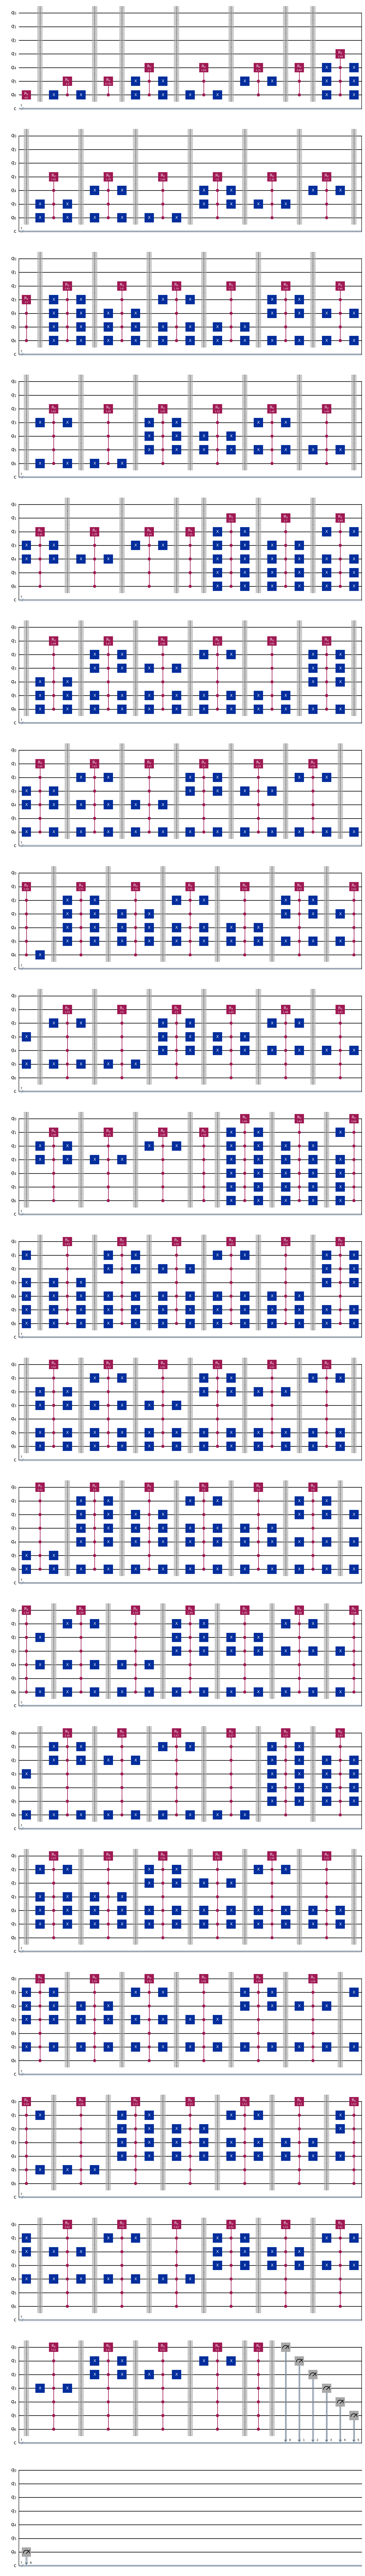

In [ ]:
def create_circuit(p):

    qc = QuantumCircuit(num_qubits,num_qubits)

    queue = deque()
    queue.append((p, [], 1))

    while queue:
        curr_p, curr_path, prev_sum = queue.popleft()

        if len(curr_p) == 1:
            continue
        
        mid = len(curr_p) // 2
        left_sum = sum(curr_p[:mid])
        theta = 2 * np.arccos(np.sqrt(left_sum / prev_sum))

        if len(curr_path) == 0:
            qc.ry(theta, num_qubits - 1) 
        else:
            control_qubits = [num_qubits - 1 - i for i in range(len(curr_path))]  
            
            not_gates = []
            for i in range(len(curr_path)):
                if curr_path[i]:
                    not_gates.append(control_qubits[i])

            qc.x(not_gates) if not_gates else None
            qc.append(RYGate(theta).control(len(curr_path)), 
                      control_qubits + [num_qubits - 1 - len(curr_path)])  
            qc.x(not_gates) if not_gates else None

        qc.barrier()
        
        queue.append((curr_p[:mid], curr_path + [True], left_sum))
        queue.append((curr_p[mid:], curr_path + [False], prev_sum - left_sum))
    qc.measure([i for i in range(num_qubits)], [i for i in range(num_qubits)])
    return qc

qc = create_circuit(p)

# NOTE uncomment next line to recieve latex source code
# print(qc.draw(output="latex_source")) 

qc.draw('mpl')

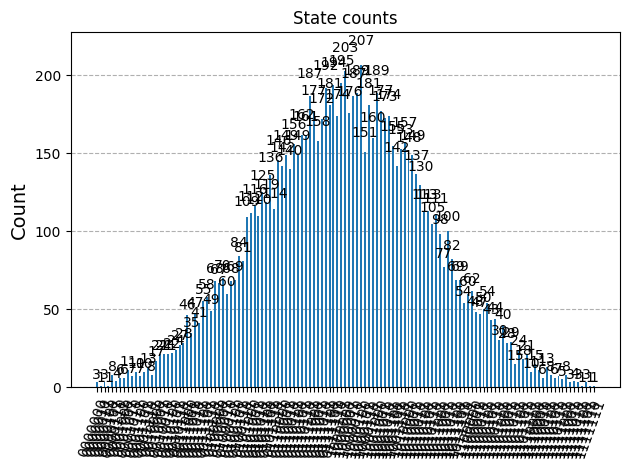

In [235]:

simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t,shots=10000).result()
counts = result.get_counts(qc_t)
plot_histogram(counts, title='State counts')